# CPA vs MultiCPA

In [1]:
import sys
sys.path.append("../../multicpa")

In [2]:
import os
import pandas as pd
import warnings
import numpy as np
import torch
import scanpy as sc
import anndata as ad
from sklearn.metrics import r2_score

In [3]:
from MultiCPA.helper import model_importer
from MultiCPA.plotting import CompertVisuals
from MultiCPA.api import ComPertAPI
from MultiCPA.plotting import ComPertHistory

In [4]:
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [6]:
os.chdir('./../')
os.getcwd()

'/mnt/home/icb/kemal.inecik/work/codes/multicpa-reproducibility'

In [9]:
DATAM = {'papalexi': {'raw_dir_name': 'Papalexi2021', 'adata_name': 'Papalexi21_prep.h5ad', 'seml': 'mpert12',
                    'nt_condition': "THP-1_NT_1.0"},
        'wessel': {'raw_dir_name': 'Wessel2022', 'adata_name': 'Wessel22_prep.h5ad', 'seml': 'mpert15',
                  'nt_condition': "THP-1_NT_1"},
        'wessel_ood': {'raw_dir_name': 'Wessel2022', 'adata_name': 'Wessel22_prep.h5ad', 'seml': 'mpert16',
                  'nt_condition': "THP-1_NT_1"},
        'wessel_ood_noprot': {'raw_dir_name': 'Wessel2022', 'adata_name': 'Wessel22_noprot_prep.h5ad', 'seml': 'mpert17',
                  'nt_condition': "THP-1_NT_1"},
        'papalexi_all': {'raw_dir_name': 'Papalexi2021', 'adata_name': 'Papalexi21_prep.h5ad', 'seml': 'mpert18',
                    'nt_condition': "THP-1_NT_1.0"},
       }

In [10]:
torch.cuda.is_available()

False

# Loading Mulpert

In [42]:
dataset = 'papalexi'
DATA = DATAM[dataset]

mulpert_models = pd.read_pickle(f"/storage/groups/ml01/workspace/kemal.inecik/seml/{DATA['seml']}/{DATA['seml']}_pickled.pk")
spt = 'test'
focus_metric_1 = f"{spt}_mean_score_genes_last"
focus_metric_2 = f"{spt}_mean_score_proteins_last"

mulpert_models = mulpert_models[(mulpert_models['status'] == 1)]
mulpert_models = mulpert_models[(mulpert_models[focus_metric_1] > 0) & (mulpert_models[focus_metric_2] > 0)]
mulpert_models["overall_best"] = np.sqrt(mulpert_models[focus_metric_1]**2 + mulpert_models[focus_metric_2]**2)

top_top = 5
mulpert_models = mulpert_models.sort_values(by=["overall_best"], ascending=False)[:top_top]
mulpert_models[["config.model.model_type", f"{'ood'}_mean_score_genes_last", f"{'ood'}_mean_score_proteins_last", f"{'training'}_mean_score_genes_last", f"{'training'}_mean_score_proteins_last", f"{'test'}_mean_score_genes_last", f"{'test'}_mean_score_proteins_last", "overall_best"]]

,config.model.model_type,ood_mean_score_genes_last,ood_mean_score_proteins_last,training_mean_score_genes_last,training_mean_score_proteins_last,test_mean_score_genes_last,test_mean_score_proteins_last,overall_best
_id,,,,,,,,
474,TotalComPert,-1.0,-1.0,0.985481,0.992076,0.976133,0.971439,1.377145
314,TotalComPert,-1.0,-1.0,0.984633,0.987444,0.977037,0.969645,1.376522
56,TotalComPert,-1.0,-1.0,0.984182,0.992995,0.975491,0.969613,1.375402
172,TotalComPert,-1.0,-1.0,0.985586,0.994579,0.975117,0.968457,1.374322
400,TotalComPert,-1.0,-1.0,0.984229,0.995738,0.975340,0.968015,1.374169


In [43]:
chosen_model = mulpert_models.index[0]
print(chosen_model)

474


In [44]:
chosen_model_entry = mulpert_models.loc[chosen_model]
mul_autoencoder, mul_datasets, mul_state, mul_history, mul_hypers = \
    model_importer(chosen_model, mulpert_models, 
                   model_dir=f"/storage/groups/ml01/workspace/kemal.inecik/seml/{DATA['seml']}/_last/", 
                   dataset_relative_to="/home/icb/kemal.inecik/work/codes/multicpa-reproducibility")
print(mul_hypers['hparams']['adversary_wd'] == mulpert_models.loc[chosen_model]['config.model.model_args.hparams.adversary_wd'])

True


# Latent Space

In [75]:
raw_data_dir = f"/storage/groups/ml01/workspace/kemal.inecik/{DATA['raw_dir_name']}"
adata = sc.read(os.path.join(raw_data_dir, DATA['adata_name']))

In [76]:
spt = "training"

dataset = mul_datasets[spt]
genes = mul_datasets[spt].raw_genes
proteins = mul_datasets[spt].raw_proteins
num, dim_genes = genes.size(0), genes.size(1)
emb_drugs = dataset.drugs.clone()
emb_cts = dataset.cell_types.clone()

genes, drugs, cell_types, proteins, _, _ = mul_autoencoder.move_inputs_(genes, emb_drugs, emb_cts, proteins, None, None)
encoder_input = torch.cat([genes, proteins], dim=-1)
latent_basal = mul_autoencoder.encoder(encoder_input)

latent_mean = None
latent_log_var = None
use_latent_mean = True
if mul_autoencoder.is_vae:
    # convert variance estimates to a positive value in [1e-3, \infty)
    dim = latent_basal.size(1) // 2
    latent_basal[:, dim:] = \
        latent_basal[:, dim:].exp().add(1).log().add(1e-3)
    latent_mean = latent_basal[:, :dim]
    latent_log_var = latent_basal[:, dim:].log()
    latent_basal = mul_autoencoder.reparameterize(latent_mean, latent_log_var)
    if use_latent_mean:
        latent_basal = latent_mean

drug_emb = mul_autoencoder.compute_drug_embeddings_(drugs)
cell_emb = mul_autoencoder.cell_type_embeddings(cell_types.argmax(1))
latent_treated = latent_basal + drug_emb + cell_emb
mul_latent_treated, mul_latent_basal = latent_treated.clone(), latent_basal.clone()
mul_latent_treated = ad.AnnData(mul_latent_treated.numpy(), obs=adata[adata.obs['split'] == 'train'].obs)
mul_latent_basal = ad.AnnData(mul_latent_basal.numpy(), obs=adata[adata.obs['split'] == 'train'].obs)

In [77]:
a1 = np.array(dataset.pert_categories)
a2 = np.array(adata[adata.obs['split'] == 'train'].obs['cov_drug_dose_name'])
np.all(a1==a2)

True

In [78]:
mul_latent_treated.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,nCount_HTO,nFeature_HTO,nCount_GDO,nFeature_GDO,nCount_ADT,nFeature_ADT,percent.mito,...,G2M.Score,Phase,n_genes,dose_val,cell_type,drug_dose_name,cov_drug_dose_name,condition,control,split
cell_ID,,,,,,,,,,,,,,,,,,,,,
l1_AAACCTGAGCCAGAAC,Lane1,17207,3942,99,4,576,111,801,4,2.295577,...,-0.771844,G1,3942,1.0,THP-1,STAT2_1.0,THP-1_STAT2_1.0,STAT2,0,train
l1_AAACCTGAGTGGACGT,Lane1,9506,2948,35,5,190,111,545,4,4.512939,...,-0.335672,G1,2948,1.0,THP-1,CAV1_1.0,THP-1_CAV1_1.0,CAV1,0,train
l1_AAACCTGTCTTGTCAT,Lane1,5135,1780,22,3,243,111,539,4,5.491723,...,-0.035986,G1,1780,1.0,THP-1,CD86_1.0,THP-1_CD86_1.0,CD86,0,train
l1_AAACGGGAGAACAACT,Lane1,9673,2671,99,5,198,111,1053,4,3.359868,...,-0.356173,G1,2671,1.0,THP-1,IRF7_1.0,THP-1_IRF7_1.0,IRF7,0,train
l1_AAACGGGAGACAGAGA,Lane1,14941,3918,97,5,124,111,487,4,3.379961,...,-0.584292,G1,3918,1.0,THP-1,NT_1.0,THP-1_NT_1.0,NT,1,train


In [79]:
mul_latent_treated.obs["Combination"] = ["NT" in i for i in mul_latent_treated.obs['condition'].str.split('+')]
mul_latent_basal.obs["Combination"] = ["NT" in i for i in mul_latent_basal.obs['condition'].str.split('+')]

mul_latent_treated_single = mul_latent_treated[mul_latent_treated.obs["Combination"]]
mul_latent_basal_single = mul_latent_basal[mul_latent_basal.obs["Combination"]]

In [80]:
adata.obs["Combination"] = ["NT" in i for i in adata.obs['condition'].str.split('+')]
adata = adata[adata.obs['split'] == 'train']
adata

View of AnnData object with n_obs × n_vars = 17593 × 4993
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nFeature_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'MULTI_classification', 'MULTI_classification.global', 'HTO_classification', 'guide_ID', 'guide_ID.global', 'gene', 'con', 'NT', 'crispr', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'n_genes', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'Combination'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'protein_names', 'rank_genes_groups_cov'
    obsm: 'protein_expression', 'protein_expression_raw'
    layers: 'counts'

In [81]:
np.array(sorted(set([i for j in mul_latent_basal.obs['condition'].str.split('+') for i in j])))

array(['ATF2', 'BRD4', 'CAV1', 'CD86', 'CMTM6', 'CUL3', 'ETV7', 'IFNGR1',
       'IFNGR2', 'IRF1', 'IRF7', 'JAK2', 'MARCH8', 'MYC', 'NFKBIA', 'NT',
       'PDCD1LG2', 'POU2F2', 'SMAD4', 'SPI1', 'STAT1', 'STAT2', 'STAT3',
       'STAT5A', 'TNFRSF14', 'UBE2L6'], dtype='<U8')

In [ ]:
# Calculate the visualizations
sc.pp.pca(mul_latent_treated)
sc.pp.neighbors(mul_latent_treated)
sc.tl.umap(mul_latent_treated)
# Calculate the visualizations
sc.pp.pca(mul_latent_basal)
sc.pp.neighbors(mul_latent_basal)
sc.tl.umap(mul_latent_basal)

In [ ]:
# Calculate the visualizations
sc.pp.pca(mul_latent_treated_single)
sc.pp.neighbors(mul_latent_treated_single)
sc.tl.umap(mul_latent_treated_single)
# Calculate the visualizations
sc.pp.pca(mul_latent_basal_single)
sc.pp.neighbors(mul_latent_basal_single)
sc.tl.umap(mul_latent_basal_single)

In [ ]:
#color = "single_perturb_groups"
#sc.pl.umap(cpa_latent_treated_single, color=color, color_map='cubehelix', title=f'CPA - Single Pert - {color}',)
#sc.pl.umap(mul_latent_treated_single, color=color, color_map='cubehelix', title=f'MulPert - Single Pert - {color}',)

In [119]:
colors = ['condition', 'Phase']

In [ ]:
#for color in colors:
#    sc.pl.umap(cpa_latent_basal_single, color=color, color_map='magma', title=f'CPA - Single Pert - {color}')
#    sc.pl.umap(mul_latent_basal_single, color=color, color_map='magma', title=f'MulPert - Single Pert - {color}')

In [ ]:
#sc.pl.umap(mul_latent_treated_single, color='condition', color_map='magma', legend_loc = 'on data',
#            title=f'MulPert - Single Pert - {color}')

In [ ]:
#for color in colors:
#    sc.pl.umap(cpa_latent_treated_single, color=color, color_map='magma', title=f'CPA - Single Pert - {color}')
#    sc.pl.umap(mul_latent_treated_single, color=color, color_map='magma', title=f'MulPert - Single Pert - {color}')

In [ ]:
#for color in colors:
#    sc.pl.umap(cpa_latent_basal, color=color, color_map='magma', title=f'CPA - Double Pert - {color}')
#    sc.pl.umap(mul_latent_basal, color=color, color_map='magma', title=f'MulPert - Double Pert - {color}')

In [120]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [121]:
m = adata.copy()

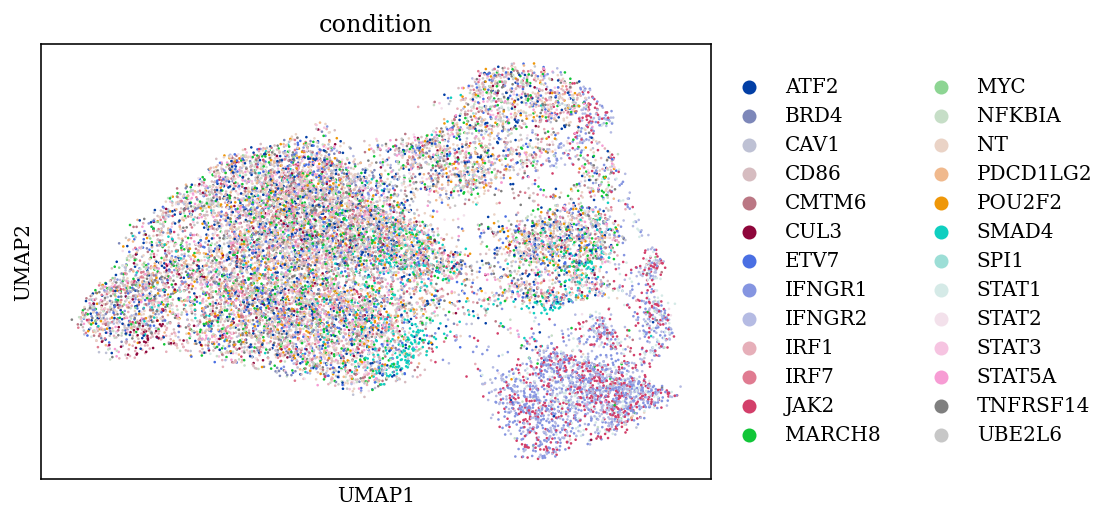

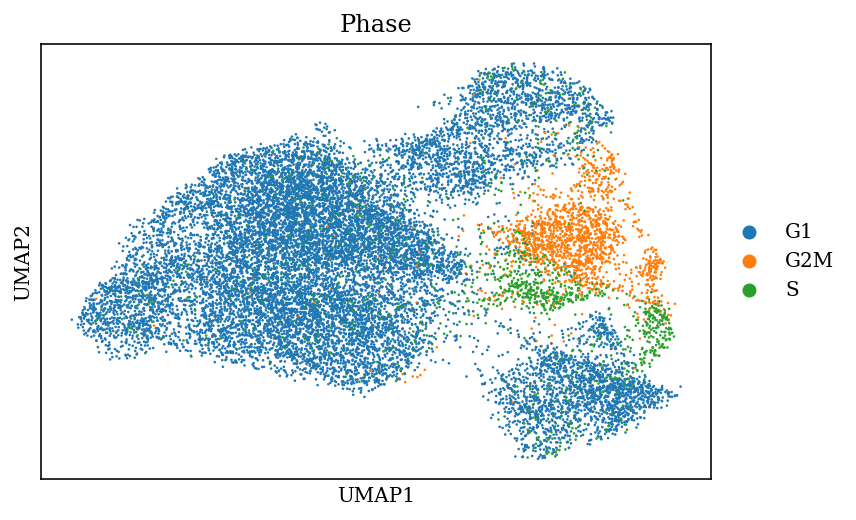

In [122]:
for color in colors:
    sc.pl.umap(m, color=color, color_map='magma');

In [123]:
pal = sns.color_palette('gray', len(m.uns['Phase_colors']))
m.uns['Phase_colors'] = list(pal.as_hex())
pal = sns.color_palette('tab10', len(m.uns['condition_colors']))
m.uns['condition_colors'] = list(pal.as_hex())

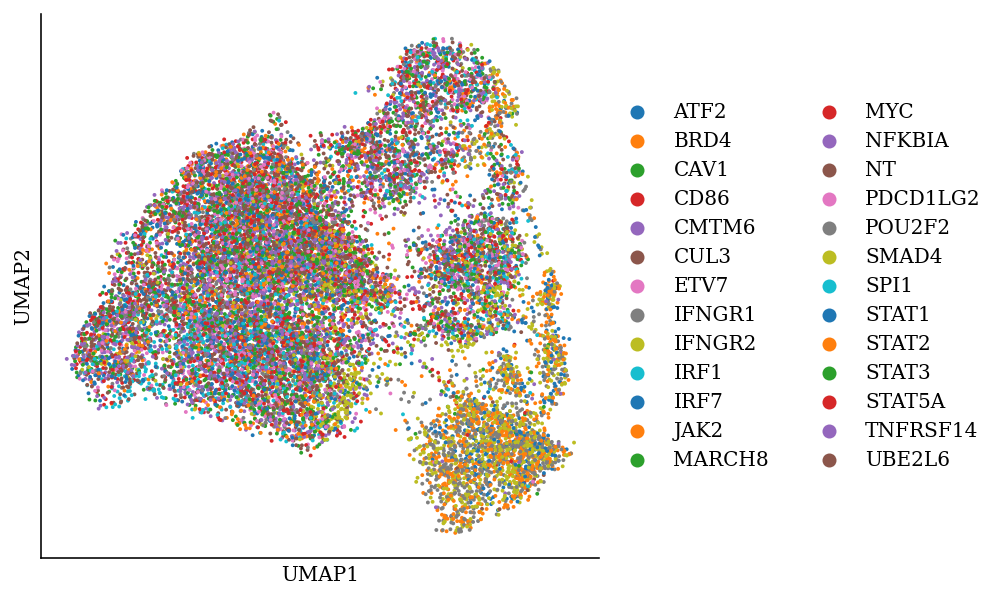

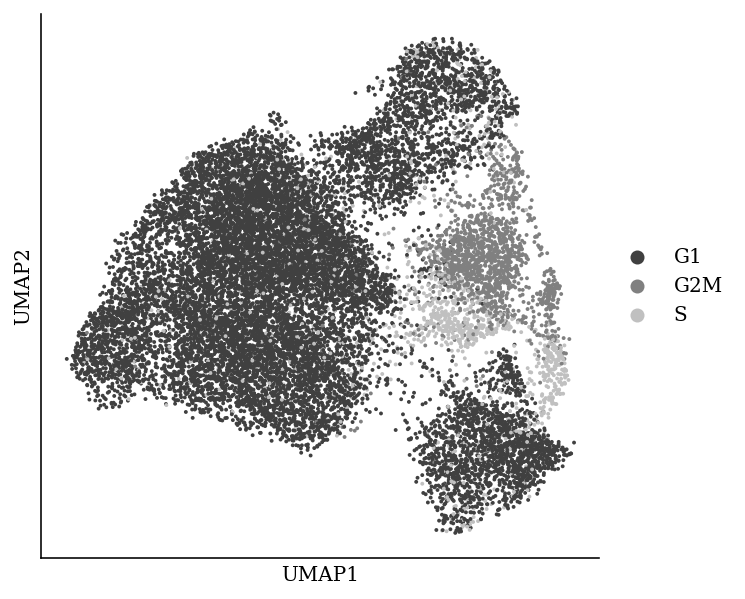

In [124]:
with plt.rc_context({
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.figsize": (5,5)
}):
    for color in colors:
        sc.pl.umap(m, color=color, size=15, title='', save=f'figures/papalexi_single_{color}.pdf')

In [ ]:
#for color in colors:
#    sc.pl.umap(cpa_latent_treated, color=color, color_map='magma', title=f'CPA - {color}')
#    sc.pl.umap(mul_latent_treated, color=color, color_map='magma', title=f'MulPert - {color}')

# Plots

In [ ]:
#raw_data_dir = f"/storage/groups/ml01/workspace/kemal.inecik/{DATA['raw_dir_name']}"
#adata = sc.read(os.path.join(raw_data_dir, DATA['adata_name']))
#adata = adata[adata.obs['split'] == 'train']
#sc.pp.pca(adata)
#sc.pp.neighbors(adata)
#sc.tl.umap(adata)

In [ ]:
#with plt.style.context({'figure.figsize':(5, 5)}):
#    for color in colors + ["replicate"]:
#        sc.pl.umap(adata, color=color,ncols=1)

In [125]:
mul_compert_api = ComPertAPI(mul_datasets, mul_autoencoder)

Print and plot drug embeddings.

In [126]:
mul_perts_anndata = mul_compert_api.get_drug_embeddings()
print(mul_perts_anndata)

AnnData object with n_obs × n_vars = 26 × 256
    obs: 'condition'


In [ ]:
#mul_perts_anndata.obs['gene_groups'] = [gene_groups[i] for i in mul_perts_anndata.obs['condition']]

In [127]:
sc.pp.pca(mul_perts_anndata)
sc.pp.neighbors(mul_perts_anndata)
sc.tl.umap(mul_perts_anndata)
sc.tl.leiden(mul_perts_anndata)
#sc.pl.umap(mul_perts_anndata, color='leiden')

In [ ]:
#sc.pp.pca(cpa_perts_anndata)
#sc.pp.neighbors(cpa_perts_anndata)
#sc.tl.umap(cpa_perts_anndata)
#sc.tl.leiden(cpa_perts_anndata)
#sc.pl.umap(cpa_perts_anndata, color='leiden')

In [ ]:
#from sklearn.metrics import silhouette_score 
#from sklearn.metrics import homogeneity_score
#ss_cpa = silhouette_score(cpa_perts_anndata.X, cpa_perts_anndata.obs['leiden'])
#ss_mul = silhouette_score(mul_perts_anndata.X, mul_perts_anndata.obs['leiden'])
#hs_mul = homogeneity_score(mul_perts_anndata.obs['gene_groups'], mul_perts_anndata.obs['leiden'])
#hs_cpa = homogeneity_score(cpa_perts_anndata.obs['gene_groups'], cpa_perts_anndata.obs['leiden'])
#ss_hs = pd.DataFrame([[ss_cpa, ss_mul, hs_mul, hs_cpa], ['AWS', 'AWS', 'Homogenity', 'Homogenity'], ['CPA', 'MulPert','MulPert','CPA']]).T
#ss_hs.columns = ['Score', 'Metric', "Model"]
#sns.barplot(data=ss_hs, y='Score', x='Metric', hue="Model", palette='gray')
#plt.show()

In [128]:
mul_perts_anndata

AnnData object with n_obs × n_vars = 26 × 256
    obs: 'condition', 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

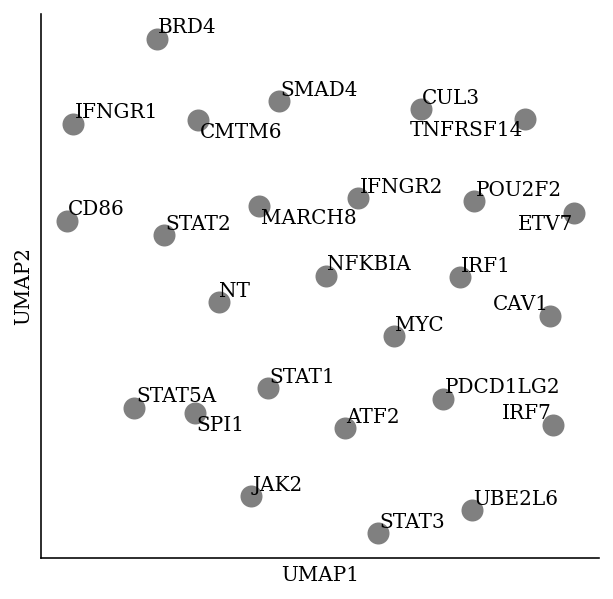

In [129]:
from adjustText import adjust_text
mul_umap = mul_perts_anndata.obsm['X_umap'].T
with plt.rc_context({"axes.spines.right": False,"axes.spines.top": False}):
    plt.figure(figsize=(5,5))
    plt.scatter(mul_umap[0], mul_umap[1], color='gray', s=100)
    adjust_text([plt.text(i, j, list(mul_perts_anndata.obs['condition'])[ind]) for ind, (i, j) in enumerate(mul_umap.T)])
    plt.gca().set_yticks([], minor=False, major=False)
    plt.gca().set_xticks([], minor=False, major=False)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.savefig(f"figures/umapfigures/papalexi_drug_embedding_mulpert.pdf")

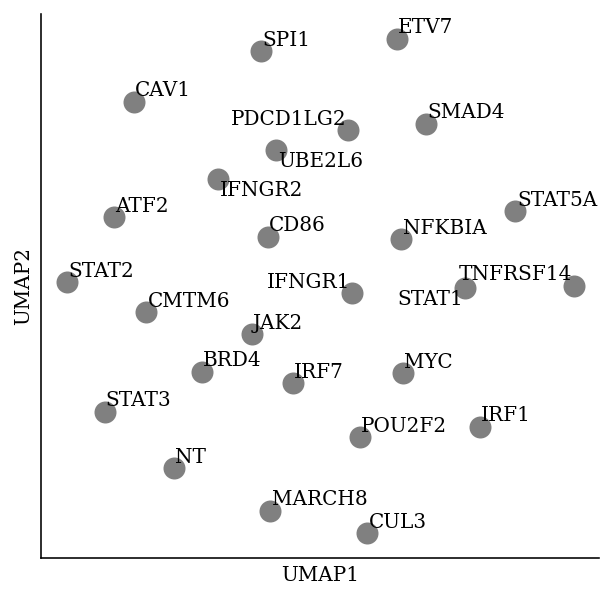

In [133]:
from adjustText import adjust_text
mul_umap = cpa_perts_anndata.obsm['X_umap'].T
with plt.rc_context({"axes.spines.right": False,"axes.spines.top": False}):
    plt.figure(figsize=(5,5))
    plt.scatter(mul_umap[0], mul_umap[1], color='gray', s=100)
    adjust_text([plt.text(i, j, list(mul_perts_anndata.obs['condition'])[ind]) for ind, (i, j) in enumerate(mul_umap.T)])
    plt.gca().set_yticks([], minor=False, major=False)
    plt.gca().set_xticks([], minor=False, major=False)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.savefig(f"figures/umapfigures/papalexi_drug_embedding_cpa.pdf")